------------------------------
開始處理第 1 個資料夾，日期為:20240415


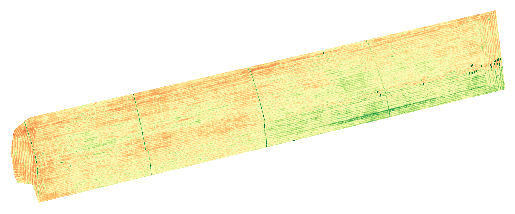

20240415_RGI_乾旱處理_(DD_1)_0.tif 統計數值:
  非零平均值: 38.9772
  中位數: 0.4313
  標準差: 25388.3164
  最大值: 35248340.0000
  最小值: 0.0015


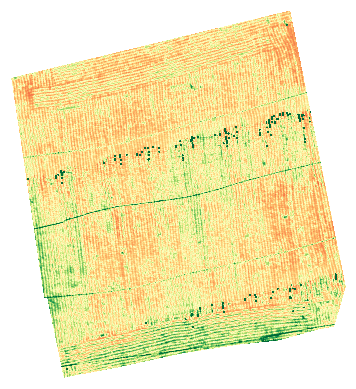

20240415_RGI_乾旱處理_(DD_2)_0.tif 統計數值:
  非零平均值: 390.1603
  中位數: 0.4174
  標準差: 80818.0156
  最大值: 47608148.0000
  最小值: 0.0015


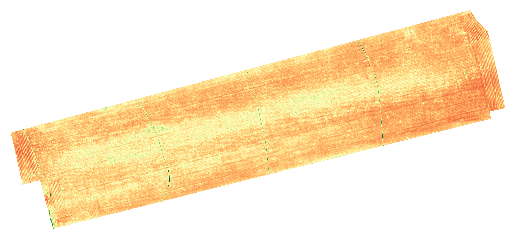

20240415_RGI_對照組_(CK)_0.tif 統計數值:
  非零平均值: 1.7356
  中位數: 0.3412
  標準差: 3259.2368
  最大值: 11444266.0000
  最小值: 0.0006
第 1 個資料夾處理結束，花費時間: 25.84 秒
------------------------------

------------------------------
開始處理第 2 個資料夾，日期為:20240513


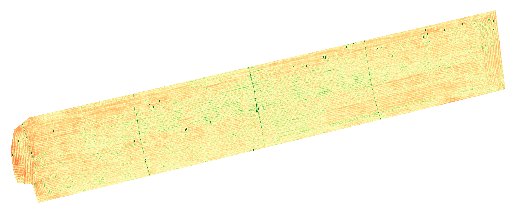

20240513_RGI_乾旱處理_(DD_1)_0.tif 統計數值:
  非零平均值: 54.9775
  中位數: 0.4083
  標準差: 39953.5391
  最大值: 103303576.0000
  最小值: 0.0011


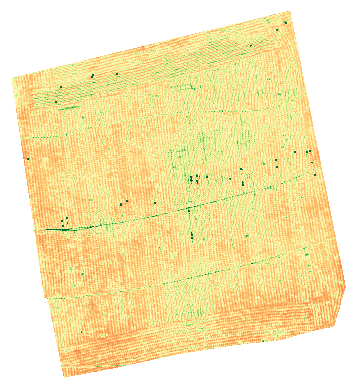

20240513_RGI_乾旱處理_(DD_2)_0.tif 統計數值:
  非零平均值: 59.4688
  中位數: 0.3782
  標準差: 29962.6387
  最大值: 39673456.0000
  最小值: 0.0037


KeyboardInterrupt: 

In [6]:
import os
import time
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 定義植生指標，只處理 RGI
VIs = ['RGI']

# 定義主要輸入文件夾
main_input_folder = '04_Result/Image/UC/ROI'

# 記錄總開始時間
total_start_time = time.time()

# 儲存所有 RGI 圖的值
all_rgi_values = []

# 遍歷 ROI 資料夾中的所有日期資料夾
for i, date in enumerate(os.listdir(main_input_folder), 1):
    input_folder = os.path.join(main_input_folder, date, 'VI')
    source_folder = os.path.join(main_input_folder, date, 'tif')

    print('------------------------------')
    print(f"開始處理第 {i} 個資料夾，日期為:{date}")
    iter_start_time = time.time()

    for VI in VIs:
        for vi_file in os.listdir(input_folder):
            if VI in vi_file and vi_file.endswith('.tif'):
                input_vi_file = os.path.join(input_folder, vi_file)
                
                # 根據 VI 去掉前綴找到對應的 source_file
                base_filename = vi_file.replace(f'{VI}_', '')
                source_file = os.path.join(source_folder, base_filename)

                # 檢查 source_file 是否存在
                if not os.path.exists(source_file):
                    print(f"Source file {source_file} does not exist, skipping.")
                    continue

                # 讀取 TIFF 檔案
                dataset = gdal.Open(input_vi_file)
                band = dataset.GetRasterBand(1)
                vi_data = band.ReadAsArray()

                # 讀取 source_file 檔案作為 mask
                dataset_source = gdal.Open(source_file)
                if dataset_source is None:
                    print(f"Failed to open {source_file}, skipping.")
                    continue
                
                try:
                    mask_band = dataset_source.GetRasterBand(7)
                except RuntimeError as e:
                    print(f"Failed to get raster band: {e}, skipping.")
                    continue

                mask_data = mask_band.ReadAsArray()

                # 檢查 mask_data 的形狀與 vi_data 是否一致
                if mask_data.shape != vi_data.shape:
                    print(f"Shape mismatch for {vi_file}: mask_data shape {mask_data.shape}, vi_data shape {vi_data.shape}")
                    continue

                mask = mask_data != 0

                # 把紅色框框的區域設為 NaN
                vi_data_masked = np.where(~mask, np.nan, vi_data)

                # 計算非零平均值、中位數、標準差、最大值和最小值（只在有圖的範圍內）
                non_zero_values = vi_data_masked[(vi_data_masked != 0) & (~np.isnan(vi_data_masked))]
                if len(non_zero_values) == 0:
                    print(f"No valid data for {vi_file}, skipping statistics.")
                    continue
                mean_value = np.mean(non_zero_values)
                median_value = np.median(non_zero_values)
                std_dev = np.std(non_zero_values)
                max_value = np.max(non_zero_values)
                min_value = np.min(non_zero_values)

                # 儲存所有 RGI 的值
                all_rgi_values.extend(non_zero_values)

                # 用中位數填補綠框內的0值
                vi_data_filled = np.where((vi_data_masked == 0) & mask, median_value, vi_data_masked)

                # 創建顏色圖譜，將 NaN 值設置為透明
                cmap = plt.get_cmap('RdYlGn')
                cmap = cmap(np.arange(cmap.N))
                cmap[:, -1] = np.where(np.isnan(cmap[:, -1]), 0, 1)  # 設置透明度
                transparent_cmap = mcolors.ListedColormap(cmap)

                # 顯示圖像並打印統計數值
                fig, ax = plt.subplots()
                im = ax.imshow(vi_data_filled, cmap=transparent_cmap, vmin=0, vmax=1)
                ax.axis('off')  # 關閉X、Y軸
                ax.set_frame_on(False)  # 去掉框框
                plt.show()

                print(f'{date}_{VI}_{base_filename} 統計數值:')
                print(f'  非零平均值: {mean_value:.4f}')
                print(f'  中位數: {median_value:.4f}')
                print(f'  標準差: {std_dev:.4f}')
                print(f'  最大值: {max_value:.4f}')
                print(f'  最小值: {min_value:.4f}')

    iter_end_time = time.time()
    print(f"第 {i} 個資料夾處理結束，花費時間: {iter_end_time - iter_start_time:.2f} 秒")
    print('------------------------------')
    print()

# 計算並顯示總時間
total_end_time = time.time()
print(f'處理完成，共花費時間: {total_end_time - total_start_time:.2f} 秒')


------------------------------
開始處理第 1 個資料夾，日期為:20240415


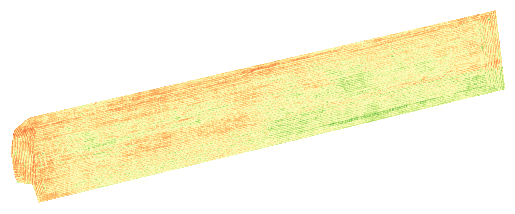

20240415_RGI_乾旱處理_(DD_1)_0.tif 統計數值:
  非零平均值: 0.4639
  中位數: 0.4263
  標準差: 0.1794
  最大值: 1.0000
  最小值: 0.0015


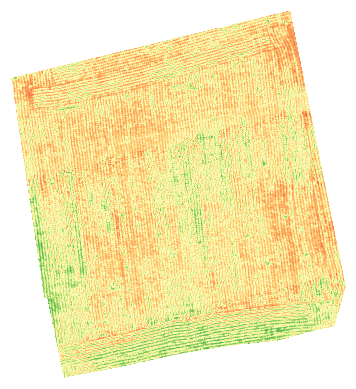

20240415_RGI_乾旱處理_(DD_2)_0.tif 統計數值:
  非零平均值: 0.4555
  中位數: 0.4131
  標準差: 0.1733
  最大值: 1.0000
  最小值: 0.0015


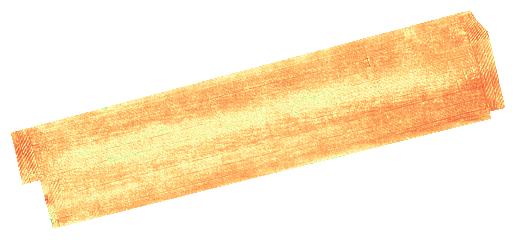

KeyboardInterrupt: 

In [11]:
import os
import time
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 定義植生指標，只處理 RGI
VIs = ['RGI']

# 定義主要輸入文件夾
main_input_folder = '04_Result/Image/UC/ROI'

# 記錄總開始時間
total_start_time = time.time()

# 儲存所有 RGI 圖的值
all_rgi_values = []

# 遍歷 ROI 資料夾中的所有日期資料夾
for i, date in enumerate(os.listdir(main_input_folder), 1):
    input_folder = os.path.join(main_input_folder, date, 'VI')
    source_folder = os.path.join(main_input_folder, date, 'tif')

    print('------------------------------')
    print(f"開始處理第 {i} 個資料夾，日期為:{date}")
    iter_start_time = time.time()

    for VI in VIs:
        for vi_file in os.listdir(input_folder):
            if VI in vi_file and vi_file.endswith('.tif'):
                input_vi_file = os.path.join(input_folder, vi_file)
                
                # 根據 VI 去掉前綴找到對應的 source_file
                base_filename = vi_file.replace(f'{VI}_', '')
                source_file = os.path.join(source_folder, base_filename)

                # 檢查 source_file 是否存在
                if not os.path.exists(source_file):
                    print(f"Source file {source_file} does not exist, skipping.")
                    continue

                # 讀取 TIFF 檔案
                dataset = gdal.Open(input_vi_file)
                band = dataset.GetRasterBand(1)
                vi_data = band.ReadAsArray()

                # 讀取 source_file 檔案作為 mask
                dataset_source = gdal.Open(source_file)
                if dataset_source is None:
                    print(f"Failed to open {source_file}, skipping.")
                    continue
                
                try:
                    mask_band = dataset_source.GetRasterBand(7)
                except RuntimeError as e:
                    print(f"Failed to get raster band: {e}, skipping.")
                    continue

                mask_data = mask_band.ReadAsArray()

                # 檢查 mask_data 的形狀與 vi_data 是否一致
                if mask_data.shape != vi_data.shape:
                    print(f"Shape mismatch for {vi_file}: mask_data shape {mask_data.shape}, vi_data shape {vi_data.shape}")
                    continue

                mask = mask_data != 0

                # 把紅色框框的區域設為0
                vi_data_masked = np.where(~mask, 0, vi_data)

                # 找到大於1的值並用相鄰的數值替換
                vi_data_masked[vi_data_masked > 1] = np.nan

                # 使用平均值替換 NaN
                vi_data_filled = vi_data_masked.copy()
                nan_mask = np.isnan(vi_data_filled)
                vi_data_filled[nan_mask] = np.nanmean(vi_data_masked)

                # 將外圍紅色的部分設為透明
                vi_data_filled_transparent = np.where(~mask, np.nan, vi_data_filled)

                # 計算非零平均值、中位數、標準差、最大值和最小值（只在有圖的範圍內）
                non_zero_values = vi_data_filled[(vi_data_filled != 0) & (~np.isnan(vi_data_filled))]
                if len(non_zero_values) == 0:
                    print(f"No valid data for {vi_file}, skipping statistics.")
                    continue

                # 儲存所有 RGI 的值
                all_rgi_values.extend(non_zero_values)

                # 創建顏色圖譜，將 NaN 值設置為透明
                cmap = plt.get_cmap('RdYlGn')
                cmap = cmap(np.arange(cmap.N))
                cmap[:, -1] = np.where(np.isnan(cmap[:, -1]), 0, 1)  # 設置透明度
                transparent_cmap = mcolors.ListedColormap(cmap)

                # 顯示圖像並打印統計數值
                fig, ax = plt.subplots()
                im = ax.imshow(vi_data_filled_transparent, cmap=transparent_cmap, vmin=0, vmax=1)
                ax.axis('off')  # 關閉X、Y軸
                ax.set_frame_on(False)  # 去掉框框
                plt.show()

                # 計算並打印統計數值
                mean_value = np.mean(non_zero_values)
                median_value = np.median(non_zero_values)
                std_dev = np.std(non_zero_values)
                max_value = np.max(non_zero_values)
                min_value = np.min(non_zero_values)

                print(f'{date}_{VI}_{base_filename} 統計數值:')
                print(f'  非零平均值: {mean_value:.4f}')
                print(f'  中位數: {median_value:.4f}')
                print(f'  標準差: {std_dev:.4f}')
                print(f'  最大值: {max_value:.4f}')
                print(f'  最小值: {min_value:.4f}')

    iter_end_time = time.time()
    print(f"第 {i} 個資料夾處理結束，花費時間: {iter_end_time - iter_start_time:.2f} 秒")
    print('------------------------------')
    print()

# 計算並顯示總時間
total_end_time = time.time()
print(f'處理完成，共花費時間: {total_end_time - total_start_time:.2f} 秒')


Mask data unique values: [0. 1.]


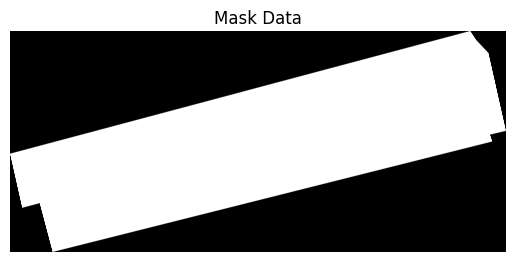

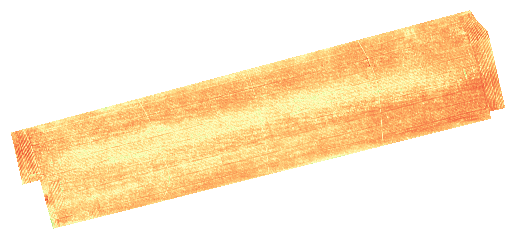

Processed VI data saved as output_vi_data.png
Number of non-zero values in VI data: 26663498
Number of non-zero values in mask data: 26663498
Max value in VI data: 0.6466739177703857
Min value in VI data: 0.0
Mean value in VI data: 0.3687373697757721


In [32]:
import os
import time
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 定義主要輸入文件夾
mask_input = r'04_Result\Image\UC\ROI\20240415\VI\RGI_對照組_(CK)_0.tif'
source_file = r'04_Result/Image/UC/ROI/20240415/tif/對照組_(CK)_0.tif'

# 讀取 TIFF 檔案作為 VI 數據
dataset_vi = gdal.Open(mask_input)
band_vi = dataset_vi.GetRasterBand(1)
vi_data = band_vi.ReadAsArray()

# 讀取 source_file 檔案作為 mask
dataset_source = gdal.Open(source_file)
mask_band = dataset_source.GetRasterBand(7)
mask_data = mask_band.ReadAsArray()

# 將 mask_data 的值縮放到 0 到 1 之間
mask_data = mask_data / 65535.0
unique_values = np.unique(mask_data)
print(f"Mask data unique values: {unique_values}")

# 將 mask_data 中的 NaN 填充為 0
mask_data = np.nan_to_num(mask_data, nan=0)

# 顯示 mask 圖像
fig, ax = plt.subplots()
ax.imshow(mask_data, cmap='gray')
ax.axis('off')  # 關閉X、Y軸
ax.set_title('Mask Data')
plt.show()

# 處理 vi_data 和 mask_data
mask = mask_data == 1  # 只選擇 mask_data 等於 1 的部分

# 把不符合 mask 的區域設為 NaN
vi_data_masked = np.where(mask, vi_data, np.nan)

# 計算 95% 百分位數
percentile_95 = np.nanpercentile(vi_data_masked, 95)

# 將大於 95% 百分位數的值替換為 95% 百分位數的值
vi_data_masked[vi_data_masked > percentile_95] = percentile_95

# 創建顏色圖譜，將 NaN 值設置為透明
cmap = plt.get_cmap('RdYlGn')
cmap = cmap(np.arange(cmap.N))
cmap[:, -1] = np.where(np.isnan(cmap[:, -1]), 0, 1)  # 設置透明度
transparent_cmap = mcolors.ListedColormap(cmap)

# 顯示處理後的 VI 數據圖像
fig, ax = plt.subplots()
im = ax.imshow(vi_data_masked, cmap=transparent_cmap, vmin=0, vmax=1)
ax.axis('off')  # 關閉X、Y軸
ax.set_frame_on(False)  # 去掉框框
plt.show()

# 保存為 PNG 圖片
output_file = 'output_vi_data.png'
plt.savefig(output_file, bbox_inches='tight', pad_inches=0, transparent=True)
plt.close()
print(f"Processed VI data saved as {output_file}")

# 計算非零值的個數
non_zero_vi_count = np.count_nonzero(~np.isnan(vi_data_masked))
non_zero_mask_count = np.count_nonzero(mask)

print(f"Number of non-zero values in VI data: {non_zero_vi_count}")
print(f"Number of non-zero values in mask data: {non_zero_mask_count}")

# 計算最大值、最小值和平均值
max_value = np.nanmax(vi_data_masked)
min_value = np.nanmin(vi_data_masked)
mean_value = np.nanmean(vi_data_masked)

print(f"Max value in VI data: {max_value}")
print(f"Min value in VI data: {min_value}")
print(f"Mean value in VI data: {mean_value}")


In [33]:
import os
import time
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 定義主要輸入文件夾
mask_input = r'04_Result\Image\UC\ROI\20240415\VI\RGI_對照組_(CK)_0.tif'
source_file = r'04_Result/Image/UC/ROI/20240415/tif/對照組_(CK)_0.tif'

# 讀取 TIFF 檔案作為 VI 數據
dataset_vi = gdal.Open(mask_input)
band_vi = dataset_vi.GetRasterBand(1)
vi_data = band_vi.ReadAsArray()

# 讀取 source_file 檔案作為 mask
dataset_source = gdal.Open(source_file)
mask_band = dataset_source.GetRasterBand(7)
mask_data = mask_band.ReadAsArray()

# 將 mask_data 的值縮放到 0 到 1 之間
mask_data = mask_data / 65535.0
unique_values = np.unique(mask_data)
print(f"Mask data unique values: {unique_values}")

# 將 mask_data 中的 NaN 填充為 0
mask_data = np.nan_to_num(mask_data, nan=0)

# 處理 vi_data 和 mask_data
mask = mask_data == 1  # 只選擇 mask_data 等於 1 的部分

# 把不符合 mask 的區域設為 NaN
vi_data_masked = np.where(mask, vi_data, np.nan)

# 計算 95% 百分位數
percentile_95 = np.nanpercentile(vi_data_masked, 95)

# 將大於 95% 百分位數的值替換為 95% 百分位數的值
vi_data_masked[vi_data_masked > percentile_95] = percentile_95

# 創建顏色圖譜，將 NaN 值設置為透明
cmap = plt.get_cmap('RdYlGn')
cmap = cmap(np.arange(cmap.N))
cmap[:, -1] = np.where(np.isnan(cmap[:, -1]), 0, 1)  # 設置透明度
transparent_cmap = mcolors.ListedColormap(cmap)

# 保存處理後的 VI 數據圖像為 PNG 圖片
fig, ax = plt.subplots()
im = ax.imshow(vi_data_masked, cmap=transparent_cmap, vmin=0, vmax=1)
ax.axis('off')  # 關閉X、Y軸
ax.set_frame_on(False)  # 去掉框框
output_file = 'output_vi_data.png'
plt.savefig(output_file, bbox_inches='tight', pad_inches=0, transparent=True)
plt.close()

print(f"Processed VI data saved as {output_file}")

# 計算非零值的個數
non_zero_vi_count = np.count_nonzero(~np.isnan(vi_data_masked))
non_zero_mask_count = np.count_nonzero(mask)

print(f"Number of non-zero values in VI data: {non_zero_vi_count}")
print(f"Number of non-zero values in mask data: {non_zero_mask_count}")

# 計算最大值、最小值和平均值
max_value = np.nanmax(vi_data_masked)
min_value = np.nanmin(vi_data_masked)
mean_value = np.nanmean(vi_data_masked)

print(f"Max value in VI data: {max_value}")
print(f"Min value in VI data: {min_value}")
print(f"Mean value in VI data: {mean_value}")


Mask data unique values: [0. 1.]
Processed VI data saved as output_vi_data.png
Number of non-zero values in VI data: 26663498
Number of non-zero values in mask data: 26663498
Max value in VI data: 0.6466739177703857
Min value in VI data: 0.0
Mean value in VI data: 0.3687373697757721
